In [ ]:
################################
########### IMPORTS ############
################################

In [1]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform, td_approximants
from pycbc.detector import Detector
import matplotlib.pyplot as plt
import numpy as np
import gwpy
import pylab
from tqdm.notebook import tqdm
from gwpy.timeseries import TimeSeries
import pandas as pd
import os
import csv
import pycbc.noise
import pycbc.psd
from pycbc.filter import matched_filter

/Users/adamvanzant/.pyenv/versions/gw_env_39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
############################################
########### BBH Data Generation ############
############################################

In [3]:

print("Generated Binary Mass Distributions for BBH")
# We can make pairs of distributions together, instead of apart.
bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50),
                                               mass2=(10, 50))

bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=5000)

Generated Binary Mass Distributions for BBH


In [ ]:
print("Using Binary Mass Distributions to generate BBH waveforms")
for i in tqdm(range(len(bbh_two_mass_samples))):
    hp, hc = get_td_waveform(approximant="SEOBNRv2",                                # what are hp and hc?
                         mass1=bbh_two_mass_samples[i][0],
                         mass2=bbh_two_mass_samples[i][1],
                         delta_t=1.0/4096,
                         f_lower=40)                                                # change to 40 Hz

    noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096)    # did not understand clearly    # try scale = 1 
    noise= noise*1e-18
    st = np.random.randint(0,2)
    
    signal = TimeSeries.from_pycbc(hp)
    
    signal.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/bbh_signal/bbh_4k_"+str(i)+".txt")
    noise.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/noise_templates/noise_4k_"+str(i)+".txt")
    
    signal.t0 = st
    data = noise.inject(signal)

    data.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/merged_bbh_noise_signal/merged_noise_signal_"+str(i)+".txt")

Using Binary Mass Distributions to generate BBH waveforms


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
import os
import csv
import pandas as pd
from tqdm import tqdm

# Define the directory paths
path = "Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/merged_bbh_noise_signal/"
output_file = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv"

# Ensure the output file is not a directory
if os.path.isdir(output_file):
    raise IsADirectoryError(f"Expected a file, but found a directory: {output_file}")

# Get the list of valid data files, excluding system files like .DS_Store
files = [f for f in os.listdir(path) if f.endswith(".csv") or f.endswith(".txt")]

# Open the output CSV file
with open(output_file, 'w', newline='') as f:
    cw = csv.writer(f)

    # Iterate through each file
    for i in tqdm(files):
        file_path = os.path.join(path, i)
        
        try:
            # ✅ Replace `delim_whitespace=True` with `sep='\s+'`
            df = pd.read_csv(file_path, sep='\s+', header=None, encoding="utf-8")
            
            # Ensure at least two columns exist before accessing the second one
            if df.shape[1] > 1:
                c = df.iloc[:, 1]  # Select the second column
                cw.writerow(c)
        
        except pd.errors.ParserError:
            print(f"Skipping {file_path} due to inconsistent column count.")
        
        except UnicodeDecodeError:
            print(f"Skipping {file_path} due to encoding error. Trying alternative encoding...")
            try:
                df = pd.read_csv(file_path, sep='\s+', header=None, encoding="ISO-8859-1")
                if df.shape[1] > 1:
                    c = df.iloc[:, 1]
                    cw.writerow(c)
            except Exception as e:
                print(f"Skipping {file_path} due to another read error: {e}")
        
        except Exception as e:
            print(f"Skipping {file_path} due to error: {e}")  # Log problematic files

100%|██████████| 5000/5000 [01:24<00:00, 59.05it/s]


In [ ]:
import os
import csv
import pandas as pd
from tqdm import tqdm

# Define paths
path_1 = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/noise_templates/"
output_file = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/Final_Merged_Noise_Reduced_No_Abs.csv"

# Ensure the output file is not a directory
if os.path.isdir(output_file):
    raise IsADirectoryError(f"Expected a file, but found a directory: {output_file}")

# Get list of valid files (ignoring system files)
files_1 = [f for f in os.listdir(path_1) if f.endswith(".txt") and os.path.isfile(os.path.join(path_1, f))]

# Open output CSV file
with open(output_file, 'w', newline='') as f1:
    cw_1 = csv.writer(f1)

    # Process each file
    for i in tqdm(files_1):
        file_path = os.path.join(path_1, i)

        try:
            # Read data without skipping but ensuring correct encoding
            df = pd.read_csv(file_path, sep=' ', header=None, encoding="utf-8")
        except UnicodeDecodeError:
            print(f"Unicode error in {file_path}, trying alternative encoding...")
            try:
                df = pd.read_csv(file_path, sep=' ', header=None, encoding="ISO-8859-1")
            except Exception as e:
                print(f"Skipping {file_path} due to error: {e}")
                continue  # Skip this file if all attempts fail
        except pd.errors.ParserError as pe:
            print(f"Parsing error in {file_path}: {pe}")
            continue  # Skip this file if it has parsing issues

        # Ensure second column exists before writing
        if df.shape[1] > 1:
            c = df.iloc[:, 1]  # Select the second column
            cw_1.writerow(c)

100%|██████████| 5000/5000 [01:23<00:00, 60.12it/s]


In [ ]:
import os
import csv
import pandas as pd
from tqdm import tqdm

# Define paths correctly
base_dir = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/"
path_1 = os.path.join(base_dir, "raw_data_files/noise_templates/")
output_file = os.path.join(base_dir, "raw_data_files/Final_Merged_Noise_Reduced_No_Abs.csv")  # Corrected path

# Ensure the output file is in the correct directory
if os.path.isdir(output_file):
    raise IsADirectoryError(f"Expected a file, but found a directory: {output_file}")

# Get list of valid files
files_1 = [f for f in os.listdir(path_1) if f.endswith(".txt") and os.path.isfile(os.path.join(path_1, f))]

# Open the correct output file
with open(output_file, 'w', newline='') as f1:
    cw_1 = csv.writer(f1)

    # Process each file
    for i in tqdm(files_1):
        file_path = os.path.join(path_1, i)

        try:
            # Read the file, ensuring correct encoding
            with open(file_path, "r", encoding="utf-8", errors="replace") as temp_file:
                first_line = temp_file.readline().strip()

            # Check if the file is empty or contains only one column
            if not first_line or " " not in first_line:
                print(f"⚠️ Skipping {file_path} because it's empty or improperly formatted.")
                continue

            df = pd.read_csv(file_path, sep=' ', header=None, encoding="utf-8", on_bad_lines="skip")

        except UnicodeDecodeError:
            print(f"⚠️ Unicode error in {file_path}, trying alternative encoding...")
            try:
                df = pd.read_csv(file_path, sep=' ', header=None, encoding="ISO-8859-1", on_bad_lines="skip")
            except Exception as e:
                print(f"❌ Skipping {file_path} due to error: {e}")
                continue  # Skip if all encoding attempts fail

        except pd.errors.ParserError as pe:
            print(f"❌ Parsing error in {file_path}: {pe}")
            continue  # Skip this file if it has parsing issues

        # Ensure second column exists before writing
        if df.shape[1] > 1:
            c = df.iloc[:, 1]  # Select the second column
            cw_1.writerow(c)

print(f"✅ Merged CSV saved to: {output_file}")

100%|██████████| 5000/5000 [01:23<00:00, 60.08it/s]

✅ Merged CSV saved to: /Users/adamvanzant/Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/Final_Merged_Noise_Reduced_No_Abs.csv


In [8]:
############################################
########### BNS Data Generation ############
############################################

In [9]:
print("Generated Binary Mass Distributions for BNS")
# We can make pairs of distributions together, instead of apart.
bns_two_mass_distributions = distributions.Uniform(mass1=(1, 2),
                                               mass2=(1, 2))

bns_two_mass_samples = bns_two_mass_distributions.rvs(size=5000)

Generated Binary Mass Distributions for BNS


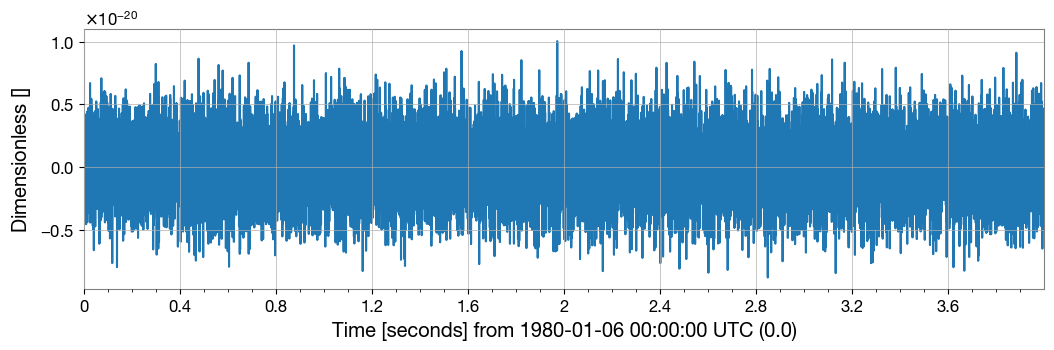

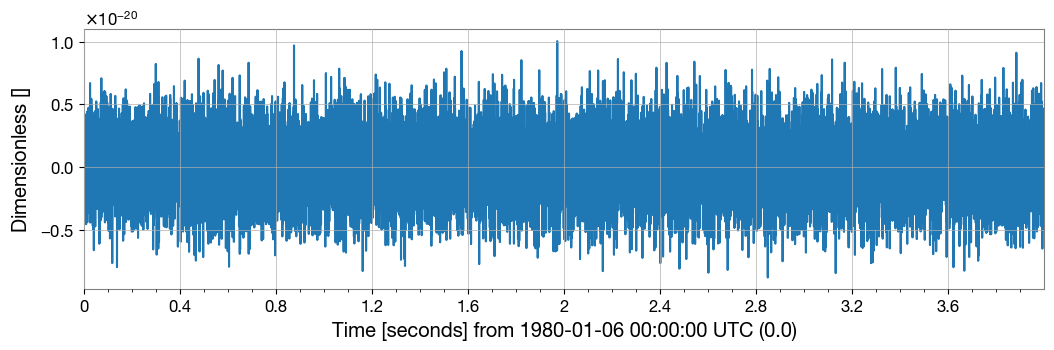

In [ ]:
i = 35
noise = TimeSeries.read("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/noise_templates/noise_4k_"+str(i)+".txt")
noise *= 0.1
noise /= 4
noise.plot()

In [ ]:
print("Using Binary Mass Distributions to generate BNS waveforms")
for i in tqdm(range(len(bns_two_mass_samples))):
    hp, hc = get_td_waveform(approximant="IMRPhenomPv2_NRTidal", 
                         mass1=bns_two_mass_samples[i][0],
                         mass2=bns_two_mass_samples[i][1],
                         delta_t=1.0/4096,
                         f_lower=40)            #change to 40   SEOBNRv2
    
    noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096)
    noise = noise*1e-18


    # Extract the last 1 sec from the BNS signal
    t = hp.get_end_time()
    hp1 = hp.time_slice(t-1, t)

    signal = TimeSeries.from_pycbc(hp1)
    signal.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/bns_signal/bns_signal_"+str(i)+".txt")

    st = np.random.randint(0,2)
    signal.t0 = st
    signal = signal.taper()


    noise = TimeSeries.read("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/noise_templates/noise_4k_"+str(i)+".txt")
    noise *= 0.1
    noise /= 4
    
    data = noise.inject(signal)

    data.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/merged_bns_noise_signal/bns_merged_noise_signal_"+str(i)+".txt")

Using Binary Mass Distributions to generate BNS waveforms


100%|██████████| 5000/5000 [31:09<00:00,  2.67it/s]


In [ ]:
# Merging Noise + Signal Templates into single csv file

import os
import csv
import pandas as pd
from tqdm import tqdm

# Define directory path
path = "Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/merged_bns_noise_signal/"
output_file = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/Final_BNS_Merged_Noise_Signal_Reduced_No_ABS.csv"

# Ensure directory exists
if not os.path.exists(path):
    raise FileNotFoundError(f"❌ The directory does not exist: {path}")

# Get only valid text files (ignore system files like .DS_Store)
files = [f for f in os.listdir(path) if f.endswith(".txt") and os.path.isfile(os.path.join(path, f))]

# Open the output CSV file
with open(output_file, 'w', newline='') as f:
    cw = csv.writer(f)

    # Iterate through each file
    for i in tqdm(files):
        file_path = os.path.join(path, i)

        try:
            # Read the file with flexible encoding handling
            df = pd.read_csv(file_path, sep=' ', header=None, encoding='utf-8', engine='python', on_bad_lines="skip")

            # If UTF-8 fails, try ISO-8859-1
            if df.shape[1] <= 1:
                df = pd.read_csv(file_path, sep=' ', header=None, encoding='ISO-8859-1', engine='python', on_bad_lines="skip")

            # Ensure at least 2 columns exist
            if df.shape[1] > 1:
                c = df.iloc[:, 1].dropna().astype(str).tolist()  # Select second column and remove NaNs
                if c:  # Only write if the column has data
                    cw.writerow(c)
                else:
                    print(f"⚠️ Skipping empty column in {file_path}")

        except UnicodeDecodeError as e:
            print(f"❌ Encoding error in {file_path}: {e}")
        except pd.errors.ParserError as e:
            print(f"❌ Parsing error in {file_path}: {e}")
        except Exception as e:
            print(f"❌ Skipping {file_path} due to unexpected error: {e}")

print(f"✅ Merging complete. Output saved to: {output_file}")

100%|██████████| 5000/5000 [03:19<00:00, 25.04it/s]

✅ Merging complete. Output saved to: /Users/adamvanzant/Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/Final_BNS_Merged_Noise_Signal_Reduced_No_ABS.csv


In [ ]:
# Merging Signal Templates into single csv file

import os
import csv
import pandas as pd
from tqdm import tqdm

# Define the directory path
path = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/bns_signal/"
output_file = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/Final_Merged_BNS_Signal.csv"

# Get the list of valid files, EXCLUDING .DS_Store and non-data files
files = [f for f in os.listdir(path) if f.endswith(".csv") or f.endswith(".txt")]

# Open the output CSV file
with open(output_file, 'w', newline='') as f:
    cw = csv.writer(f)

    # Track actual row count
    row_count = 0

    # Iterate through each file
    for i in tqdm(files, desc="Processing Files"):
        file_path = os.path.join(path, i)
        
        try:
            df = pd.read_csv(file_path, sep=' ', header=None, encoding='ISO-8859-1')

            if df.shape[1] > 1:  # Ensure the second column exists
                c = df.iloc[:, 1]  # Select the second column
                cw.writerow(c)
                row_count += 1  # Count only valid rows
        except Exception as e:
            print(f"Skipping {file_path} due to error: {e}")

print(f"Total rows written: {row_count}")

Processing Files: 100%|██████████| 5000/5000 [00:23<00:00, 213.90it/s]

Total rows written: 5000


In [14]:
###########################################
############ SNR CALCULATION ##############
###########################################

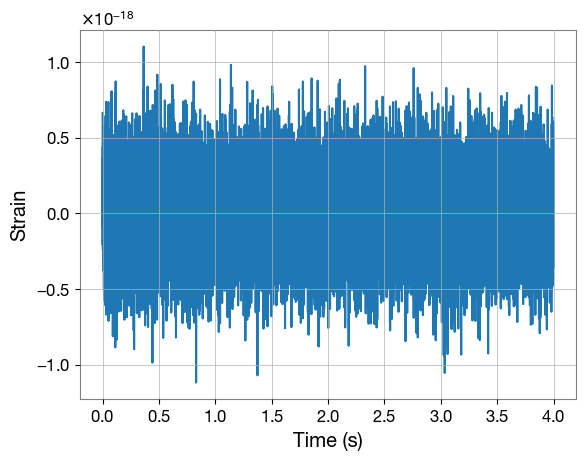

In [15]:
# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 4 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(4 / delta_t)
noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
noise *= 1e3

plt.plot(noise.sample_times, noise)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

noise1 = TimeSeries.from_pycbc(noise)

Generated Binary Mass Distributions for BBH


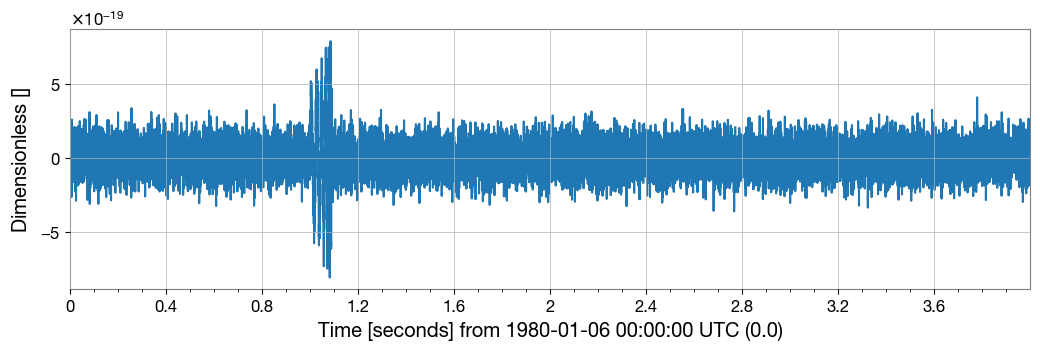

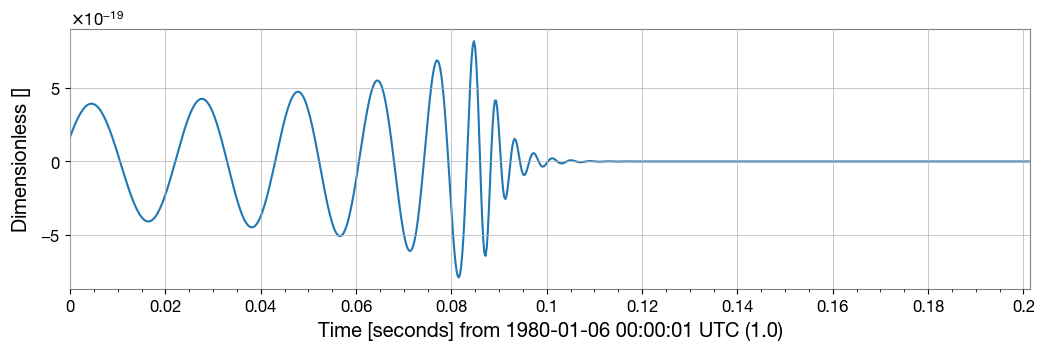

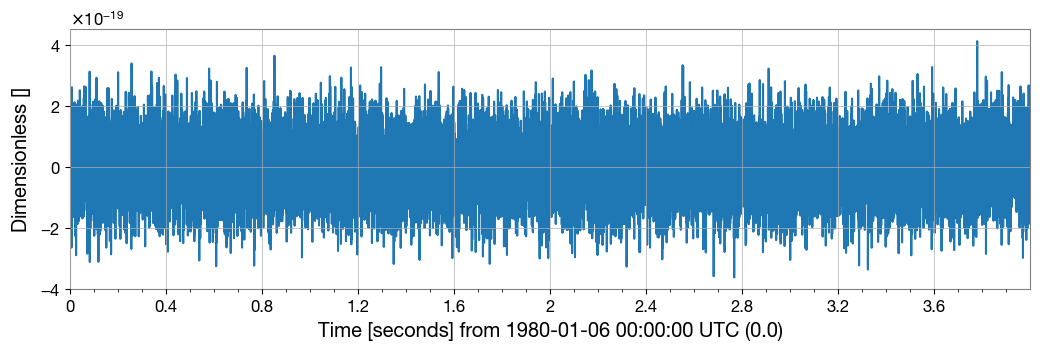

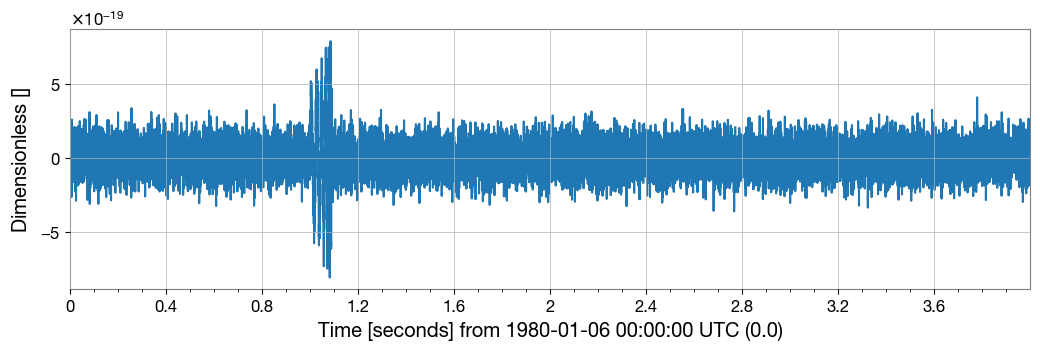

In [16]:

print("Generated Binary Mass Distributions for BBH")
# We can make pairs of distributions together, instead of apart.
bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50),
                                               mass2=(10, 50))

bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=1)

hp, hc = get_td_waveform(approximant="SEOBNRv2",                                # what are hp and hc?
                         mass1=bbh_two_mass_samples[0][0],
                         mass2=bbh_two_mass_samples[0][1],
                         delta_t=1.0/4096,
                         f_lower=40)

signal = TimeSeries.from_pycbc(hp)
signal.t0 = 1
signal.plot()

noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096) 
noise1 = (noise*1e-18)
noise1.plot()

merged_bbh = noise1.inject(signal)
merged_bbh.plot()

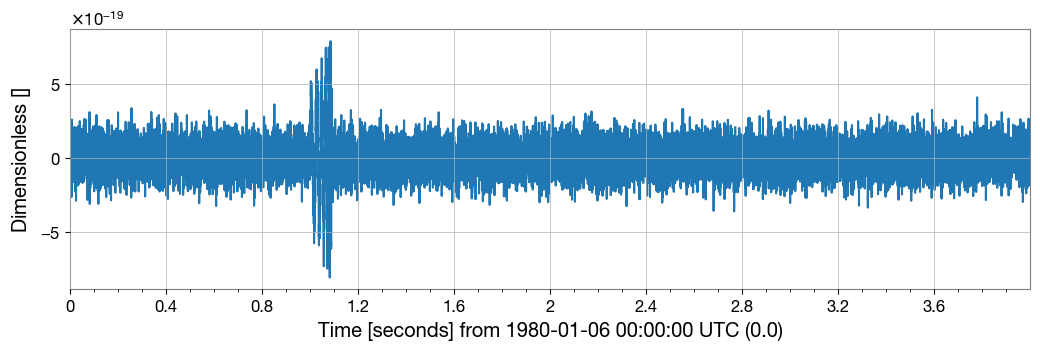

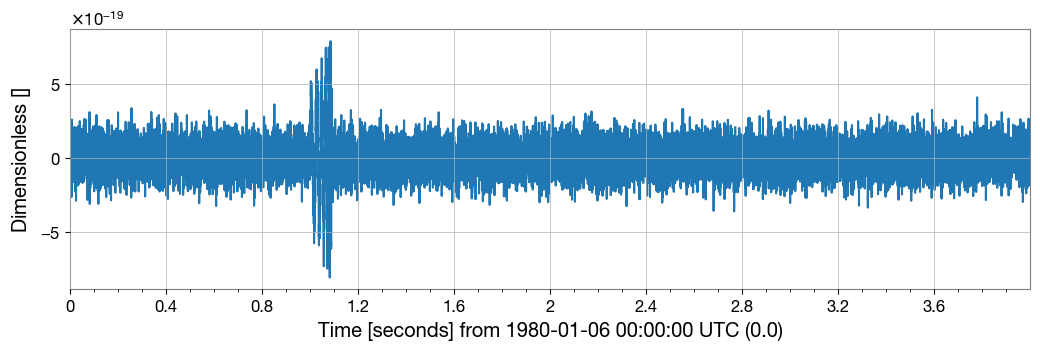

In [17]:
merged_bbh = noise1.inject(signal)
merged_bbh.plot()

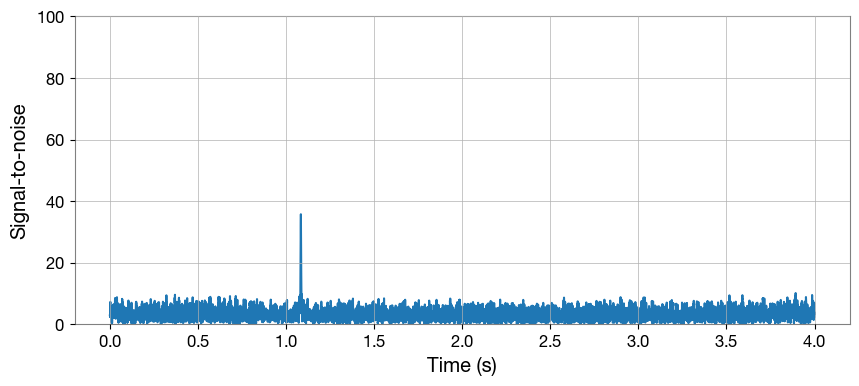

We found a signal at 1.083984375s with SNR 35.7421176298252


In [18]:
hp.resize(len(merged_bbh))
hp = hp.cyclic_time_shift(hp.start_time)

high = merged_bbh.highpass(15)
psd = merged_bbh.psd()

snr = matched_filter(hp, merged_bbh.to_pycbc(), psd=psd.to_pycbc(),
                     low_frequency_cutoff=15)
snrts = TimeSeries.from_pycbc(snr).abs()

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.ylim(0, 100)
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [19]:
###################################
############ WHITENING ############
###################################

[(14.38601282, 30.42747537)]


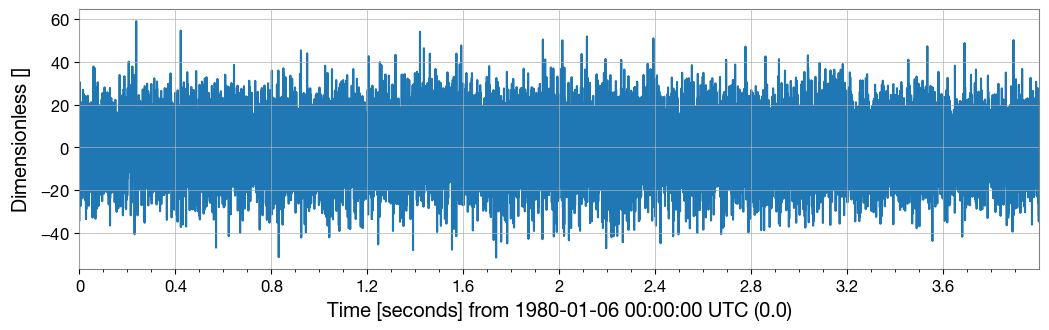

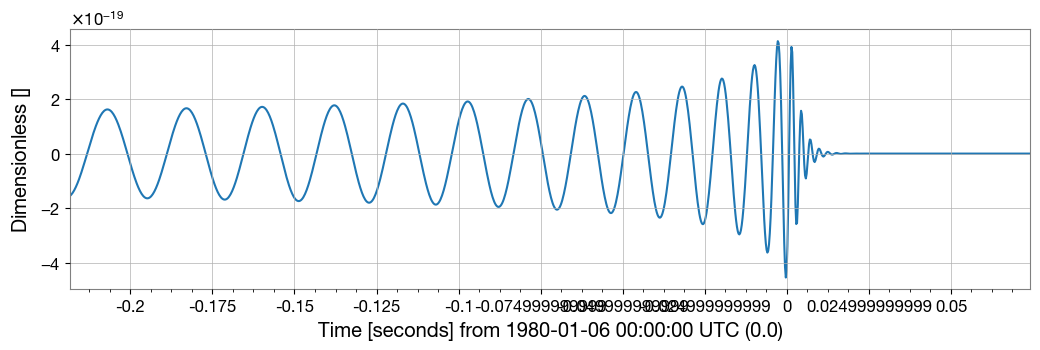

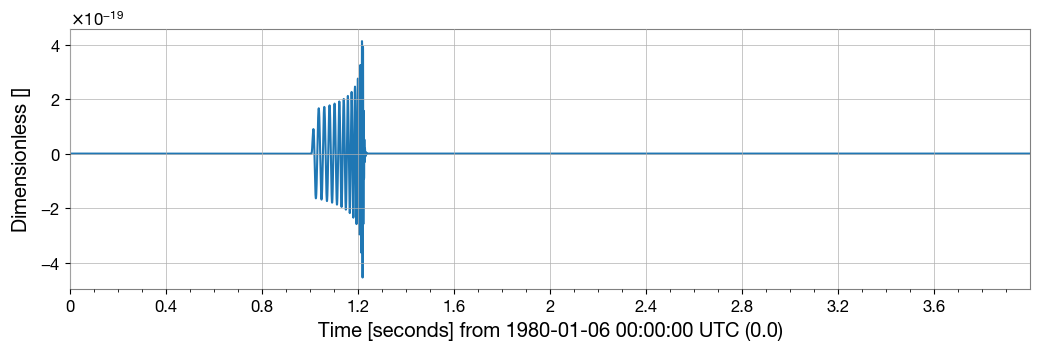

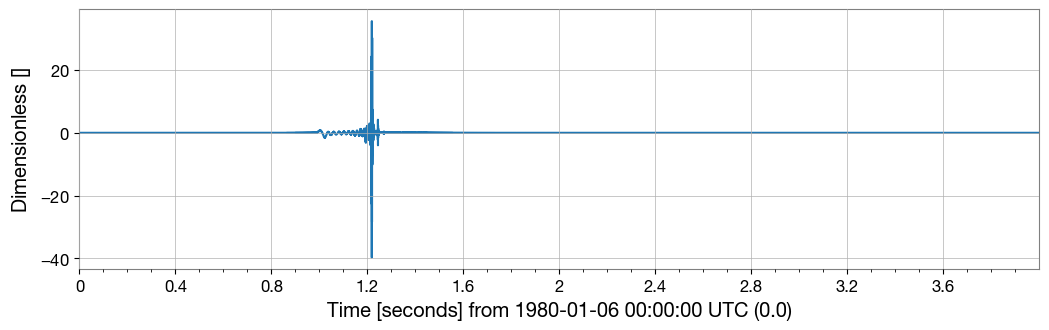

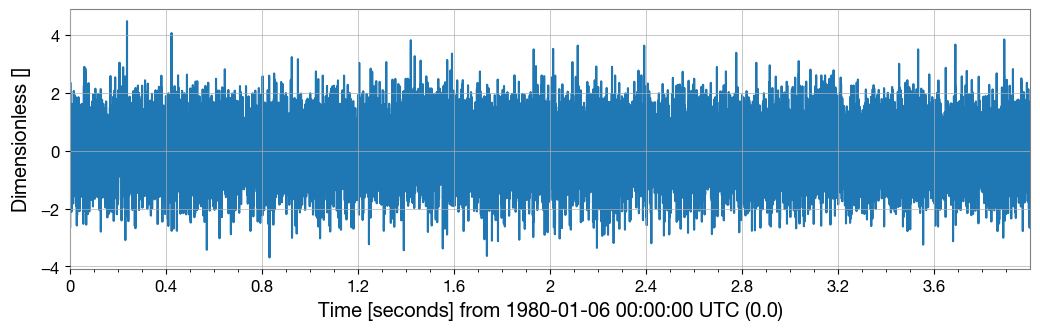

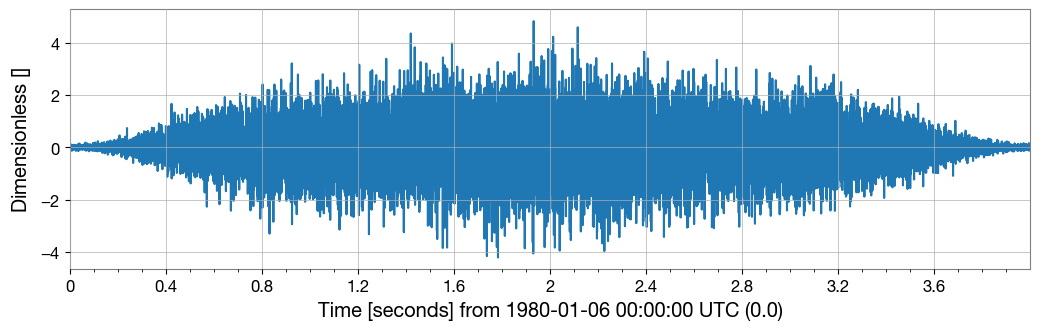

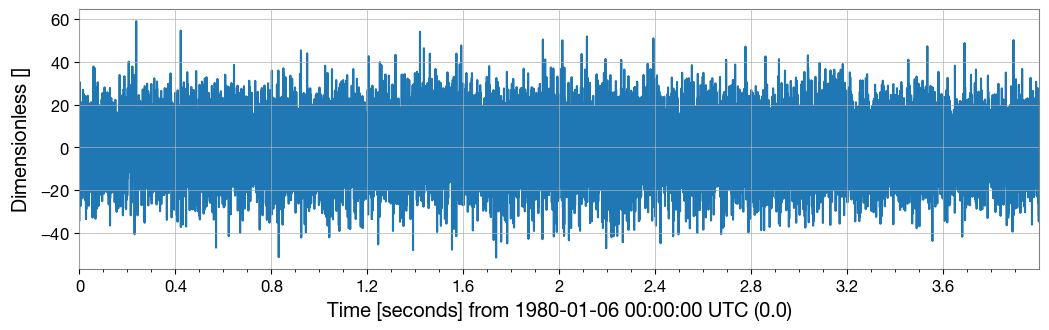

In [20]:
# This code cell demonstrates the method and effect of whitening on signals.

from pycbc.waveform import get_td_waveform
from gwpy.timeseries import TimeSeries
import numpy as np
from pycbc.distributions import Uniform
import matplotlib.pyplot as plt

# Generate random masses
bbh_two_mass_distributions = Uniform(mass1=(10, 50), mass2=(10, 50))
bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=1)
print(bbh_two_mass_samples)

# Generate waveform
hp, hc = get_td_waveform(approximant='SEOBNRv2',
                         mass1=bbh_two_mass_samples[0][0],
                         mass2=bbh_two_mass_samples[0][1],
                         delta_t=1.0/4096,
                         f_lower=40)

# Convert waveform to TimeSeries
signal = TimeSeries.from_pycbc(hp)
signal.plot()

# Apply taper and set start time
signal = signal.taper()
signal.t0 = 1

# ✅ Fix: Ensure `noise` is a float array before scaling
noise = TimeSeries(np.zeros(16384, dtype=float), sample_rate=4096)

# Scale noise
noise *= 1e-18

# Inject signal into noise
data = noise.inject(signal)
data.plot()

# Apply whitening
white = data.whiten()
white.plot()

# ✅ Additional Noise Generation (Alternative)
noise = TimeSeries(np.random.normal(scale=1, size=16384), sample_rate=4096)  
noise.plot()

# Scale the noise
noise *= 13

# Apply whitening
white1 = noise.whiten()
white1.plot()

# Inject whitened signal into noise
data1 = noise.inject(white1)
data1.plot()

In [21]:
bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50),
                                               mass2=(10, 50))

bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=1)

hp, hc = get_td_waveform(approximant="SEOBNRv2",                                
                         mass1=bbh_two_mass_samples[0][0],
                         mass2=bbh_two_mass_samples[0][1],
                         delta_t=1.0/4096,
                         f_lower=40)

st = 1
signal = TimeSeries.from_pycbc(hp)
signal.t0 = st

noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096)

In [22]:
# No whitening

s1 = signal/(max(signal.max(), np.abs(signal.min()))/0.2)

d1 = noise.inject(s1)

# Whitening after injection

s2 = signal/(max(signal.max(), np.abs(signal.min()))/0.2)
tmp2 = noise.inject(s2)

d2 = tmp2.whiten()
d2 /= 10

# Whitening only signal before injection

n3 = TimeSeries(np.zeros(16384, dtype=float), sample_rate=4096)  # Ensure dtype is float64
tmp3 = n3.inject(signal)  # Now signal (float64) is safely injected
tmp3 = tmp3.whiten()
s3 = tmp3 / (max(tmp3.max(), np.abs(tmp3.min())) / 0.2)

d3 = noise.inject(s3)

# Whitening only noise before injection

tmp4 = (noise.whiten())/10

s4 = signal/(max(signal.max(), np.abs(signal.min()))/0.2)

d4 = tmp4.inject(s4)


# Whitening both before injection

tmp5 = (noise.whiten()) / 10

n5 = TimeSeries(np.zeros(16384, dtype=float), sample_rate=4096)  # Ensure dtype is float64
tmp6 = n5.inject(signal)  # Now signal (float64) is safely injected
tmp6 = tmp6.whiten()
s5 = tmp6 / (max(tmp6.max(), np.abs(tmp6.min())) / 0.2)

d5 = tmp5.inject(s5)

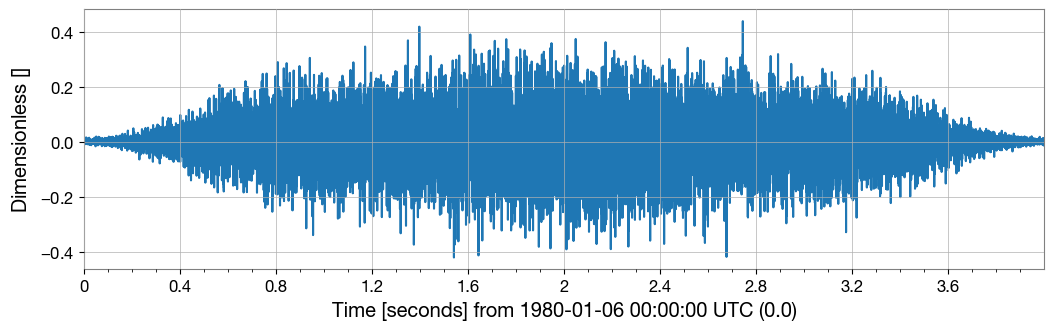

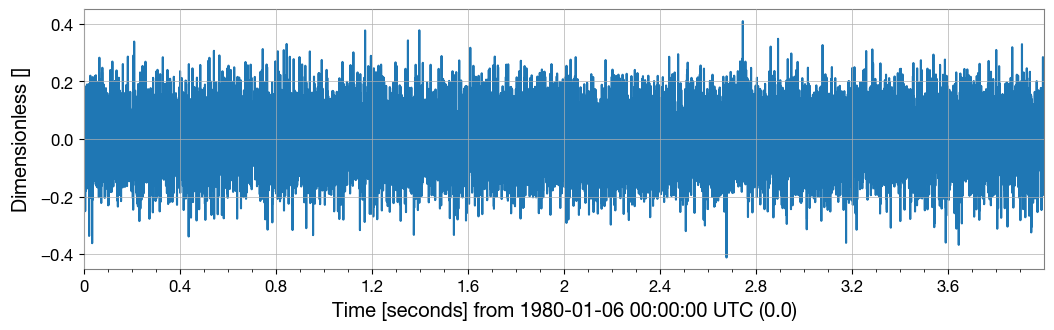

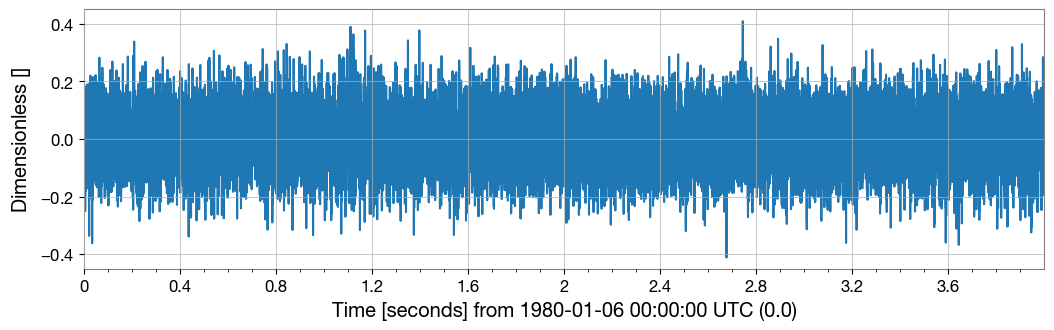

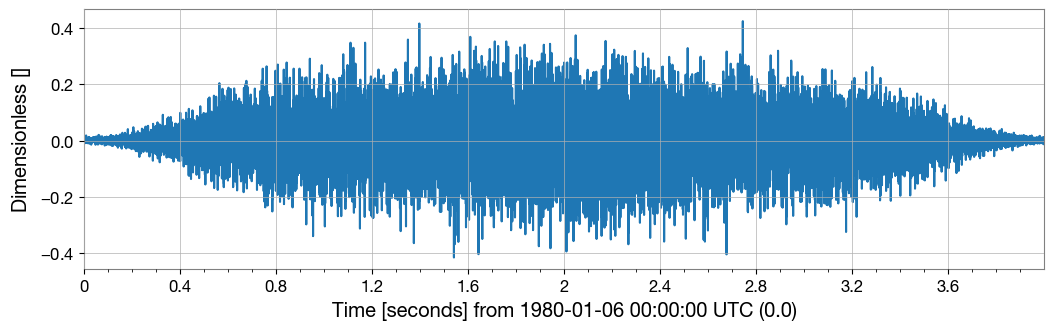

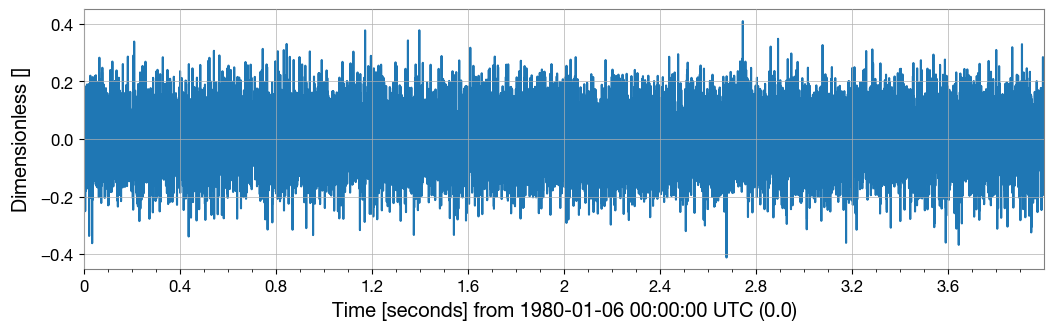

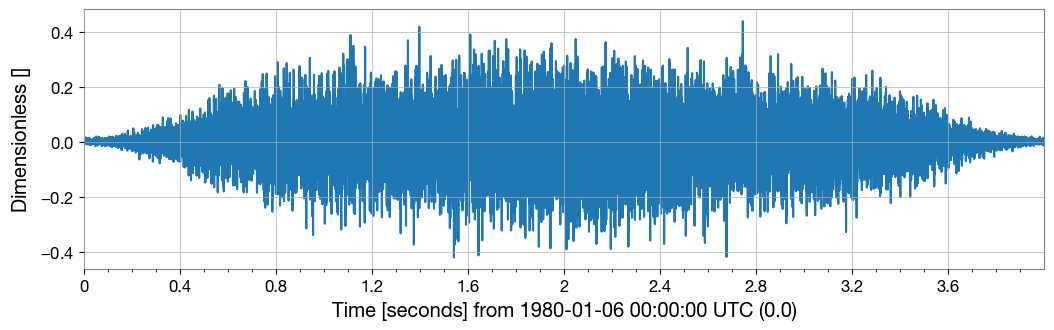

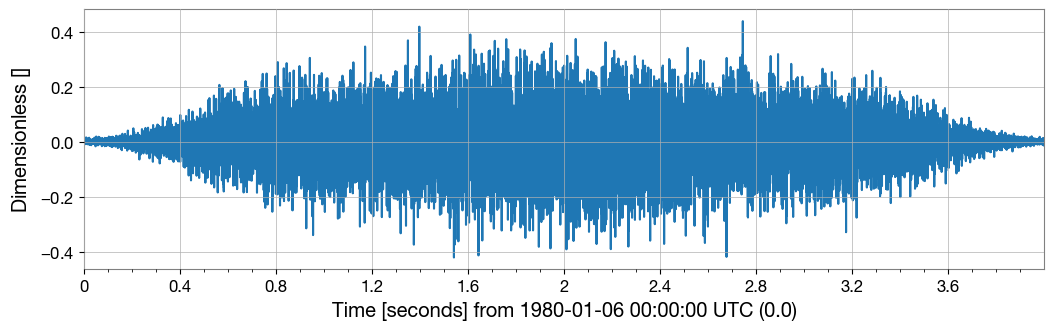

In [23]:
noise.plot()
d1.plot()
d2.plot()
d3.plot()
d4.plot()
d5.plot()

In [24]:
#################################################
############ DATASET DEBUGGING START ############
#################################################

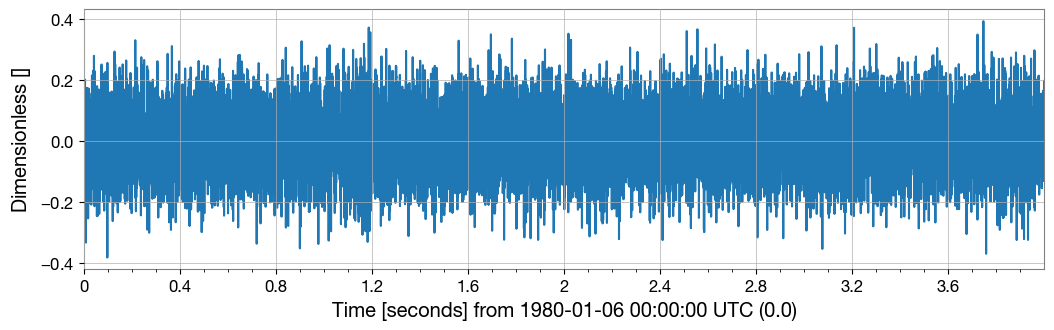

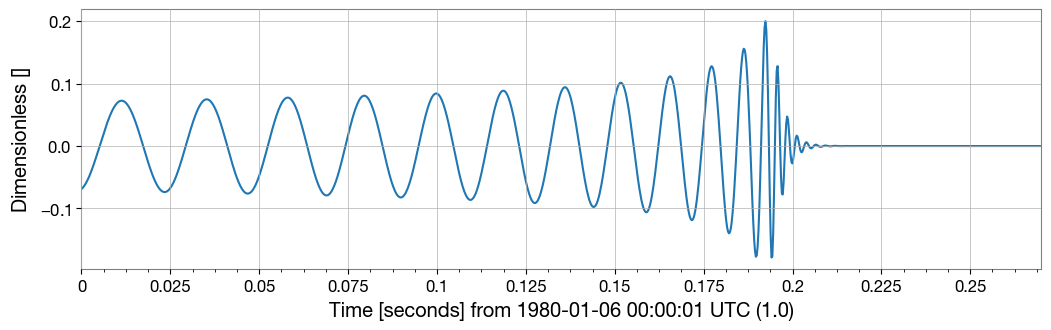

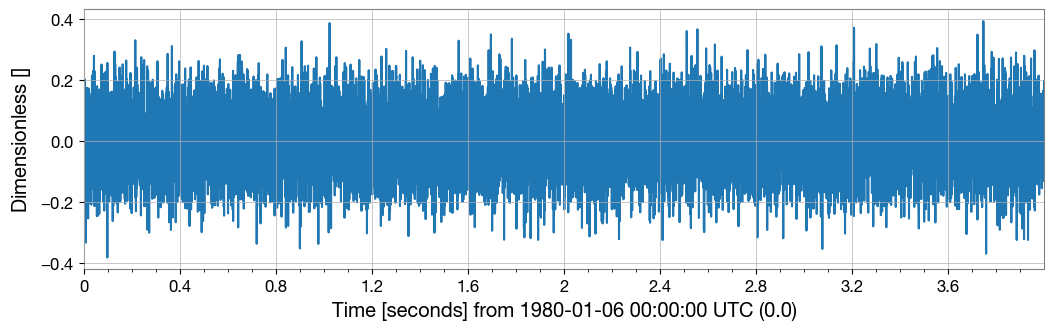

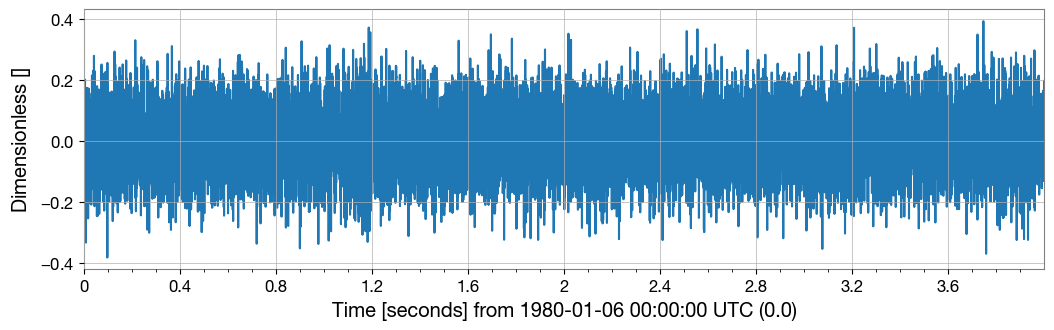

In [25]:
bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50),
                                               mass2=(10, 50))

bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=1)

hp, hc = get_td_waveform(approximant="SEOBNRv2",                                
                         mass1=bbh_two_mass_samples[0][0],
                         mass2=bbh_two_mass_samples[0][1],
                         delta_t=1.0/4096,
                         f_lower=40)

st = 1
signal = TimeSeries.from_pycbc(hp)
signal.t0 = st

noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096)

s1 = signal/(max(signal.max(), np.abs(signal.min()))/0.2)

d1 = noise.inject(s1)

s1.plot()
noise.plot()
d1.plot()

In [26]:
a = np.random.normal(scale=.1, size=16384)      #scale is standard deviation. Why is scale = 0.1?
print(a, a.shape, np.mean(a), np.std(a))

## 	scale=0.1 ensures the noise stays small and doesn’t dominate the real signal.
##	this makes the generated noise similar to real gravitational wave detector noise.
##	can tweak scale to experiment with different noise intensities.
##

[-0.10748615  0.05399909  0.3719996  ... -0.09606513 -0.12936103
 -0.02155151] (16384,) -0.0011038406928830942 0.10054449011130896


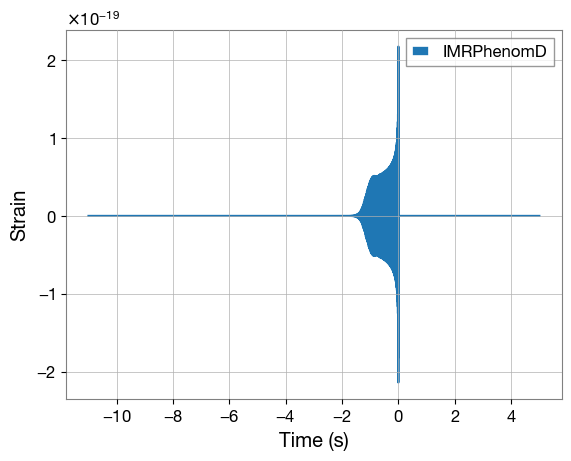

In [27]:
for apx in ['IMRPhenomD']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=10,
                                 mass2=10,
                                 spin1z=0.9,
                                 delta_t=1.0/4096,
                                 f_lower=40)

    plt.plot(hp.sample_times, hp, label=apx)

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

1.6032559510971593 1.6367254148533255


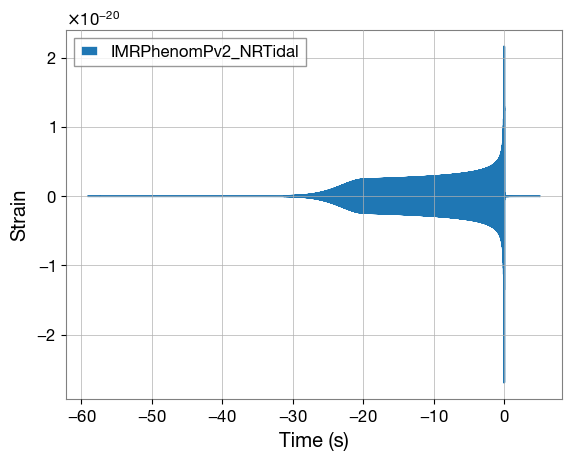

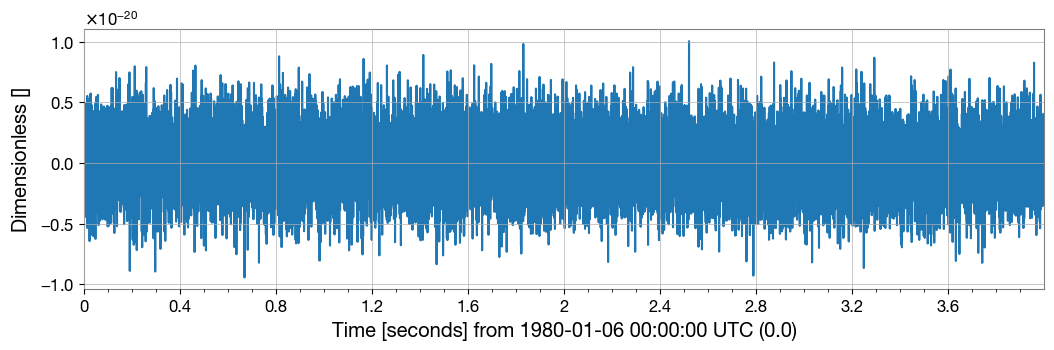

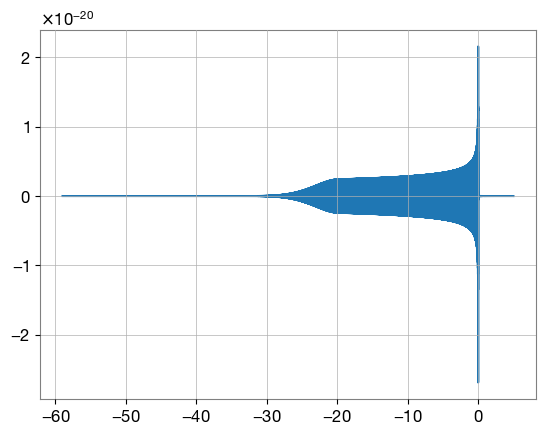

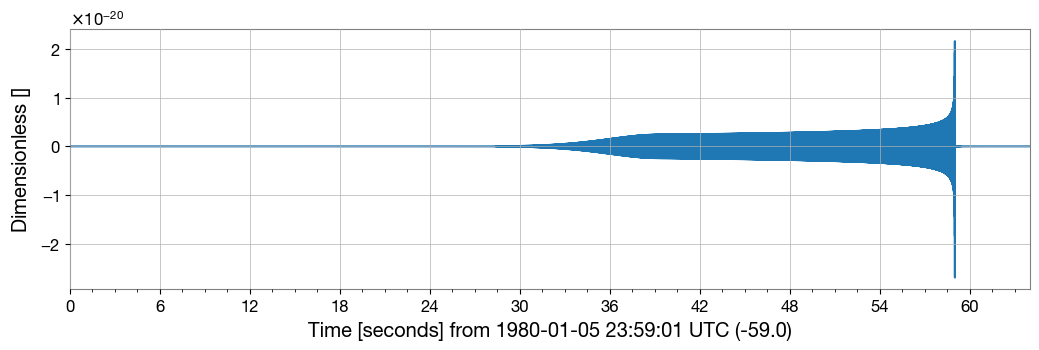

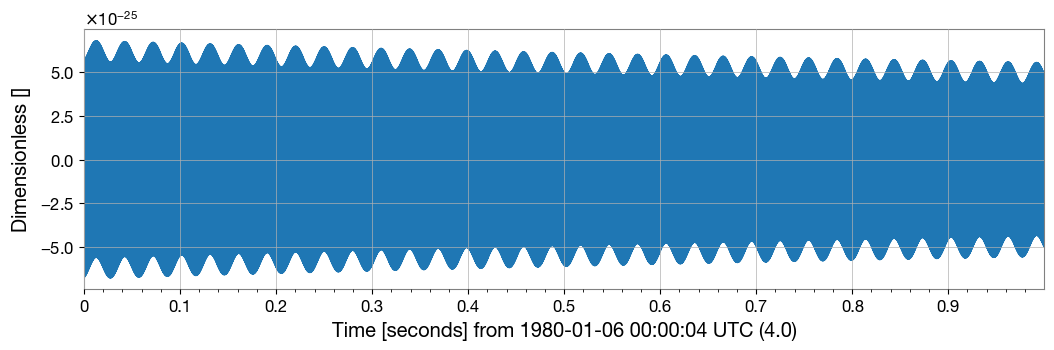

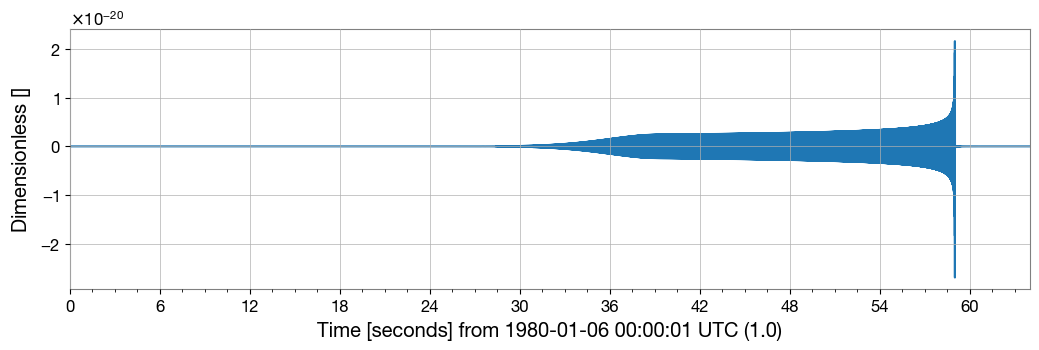

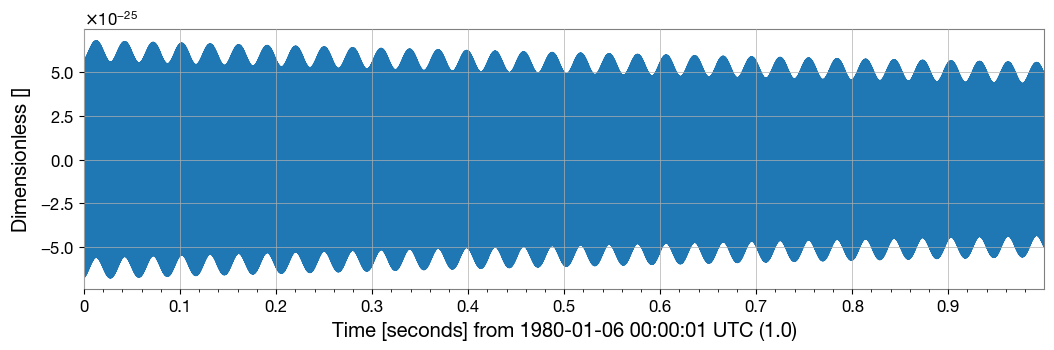

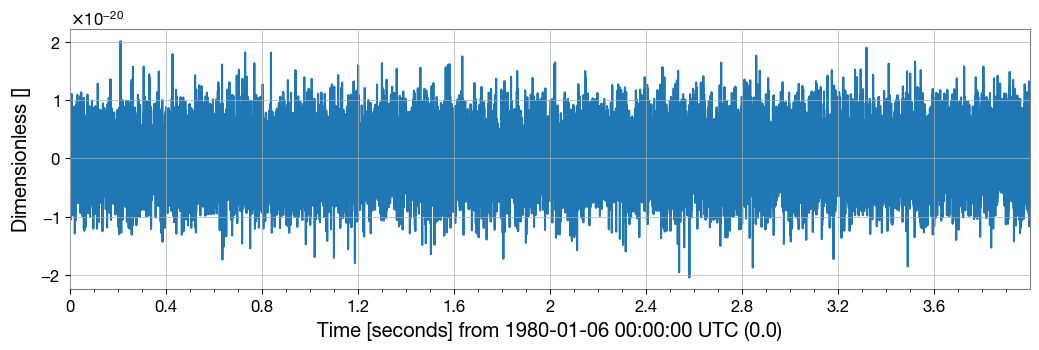

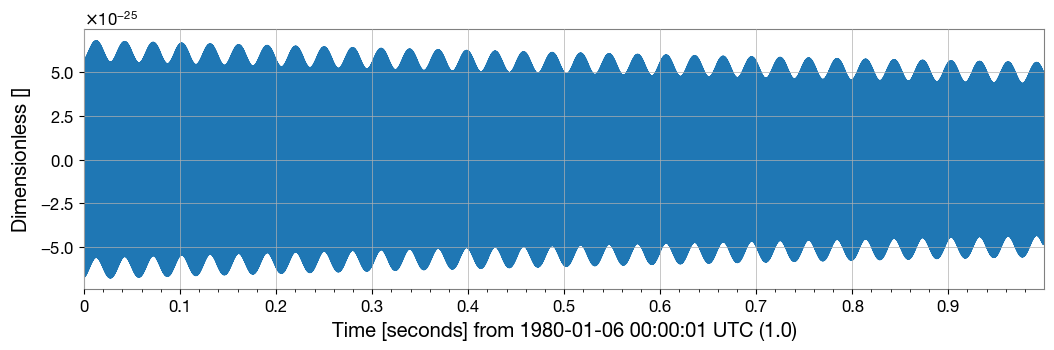

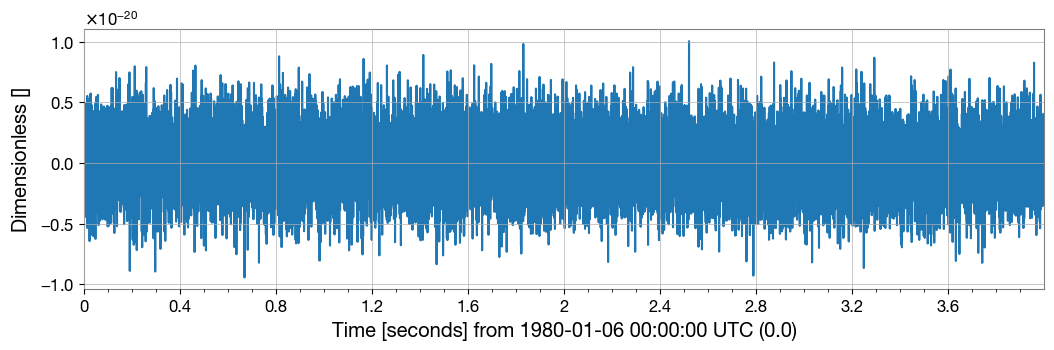

In [28]:
# This code cell shows the major time duration difference between the BNS signal and the noise.
# The noise is only 4 secs long but the BNS signal durartion varies from 120s - 60s as shown in the plots below.
# When the BNS signal is injected in the noise, only it's first 4 secs are taken which is a flatline, i.e. it has no signal
# This code cell can also extract the last 't' secs of the BNS signal and then inject into the noise
# This code cell also demonstrates tapering, which is used to prevent the "ringing" problem
####### important: Notice the major difference in the amplitude of the noise and the BNS signal. Do something about it.


bns_two_mass_distributions = distributions.Uniform(mass1=(1, 2),
                                               mass2=(1, 2))

bns_two_mass_samples = bns_two_mass_distributions.rvs(size=1)
print(bns_two_mass_samples[0][0], bns_two_mass_samples[0][1])

hp, hc = get_td_waveform(approximant='IMRPhenomPv2_NRTidal',
                                mass1=bns_two_mass_samples[0][0],
                                mass2=bns_two_mass_samples[0][1],
                                delta_t=1.0/4096,
                                f_lower=40)

plt.plot(hp.sample_times, hp, label='IMRPhenomPv2_NRTidal')

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

hp.plot()
t = hp.get_end_time()
hp1 = hp.time_slice(t-1, t)

signal = TimeSeries.from_pycbc(hp)
signal1 = TimeSeries.from_pycbc(hp1)

signal.plot()
signal1.plot()

signal.t0 = 1
signal.plot()

signal1.t0 = 1
signal1.plot()

noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096)
noise *= 1e-19
noise /= 2

data = noise.inject(signal)
data.plot()

signal1 = signal1.taper()
signal1.plot()

noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096)
noise *= 1e-19
noise /= 4

data = noise.inject(signal1)
data.plot()


[(19.83336622, 11.18502676)]


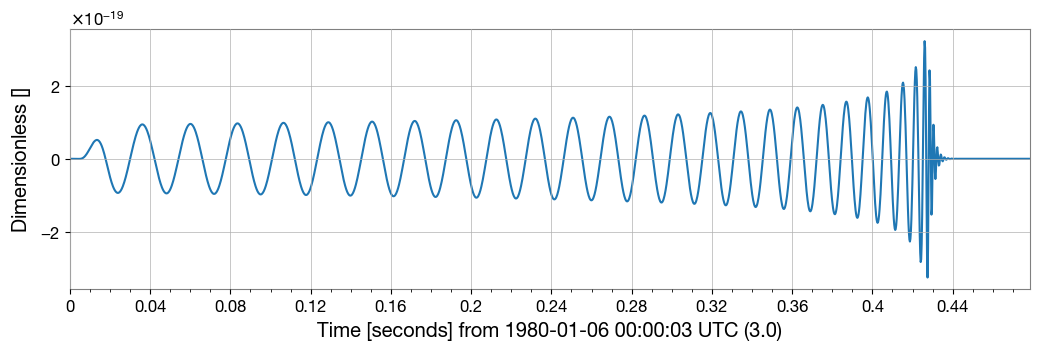

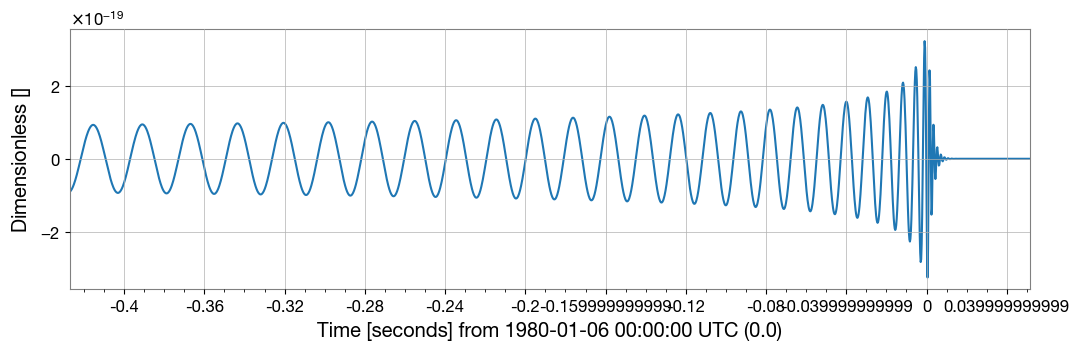

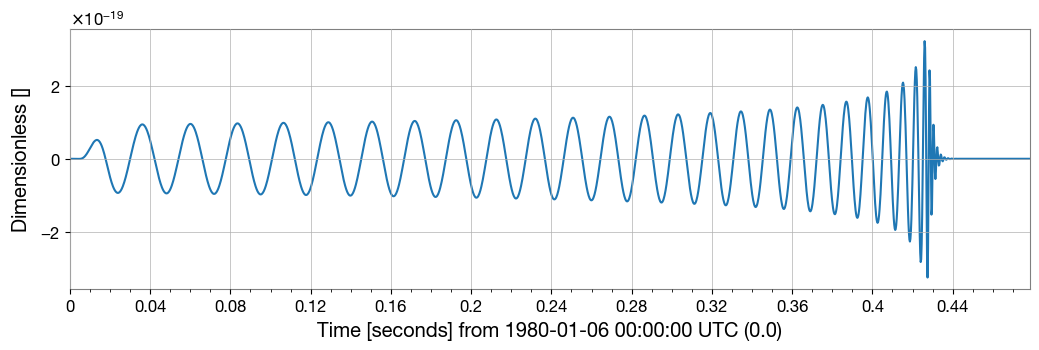

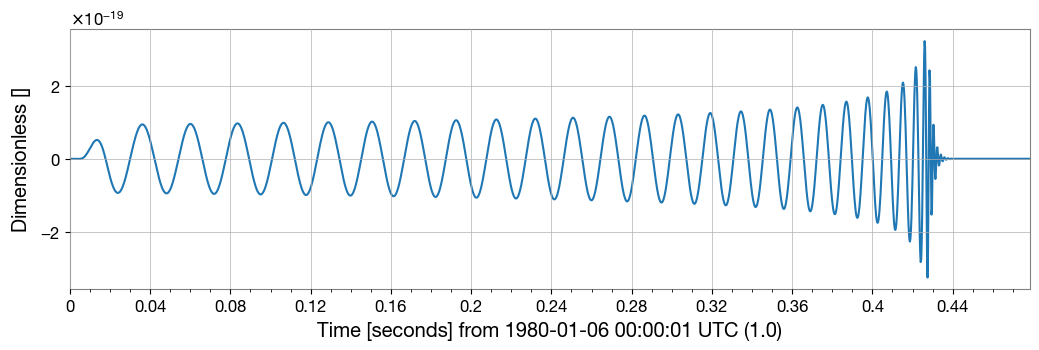

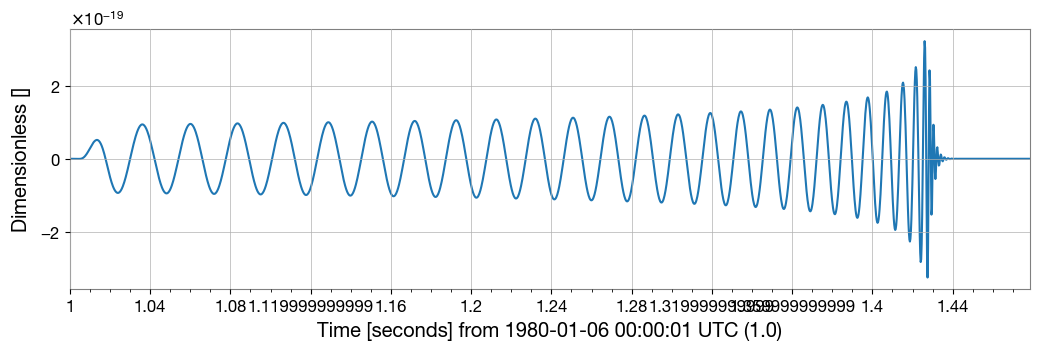

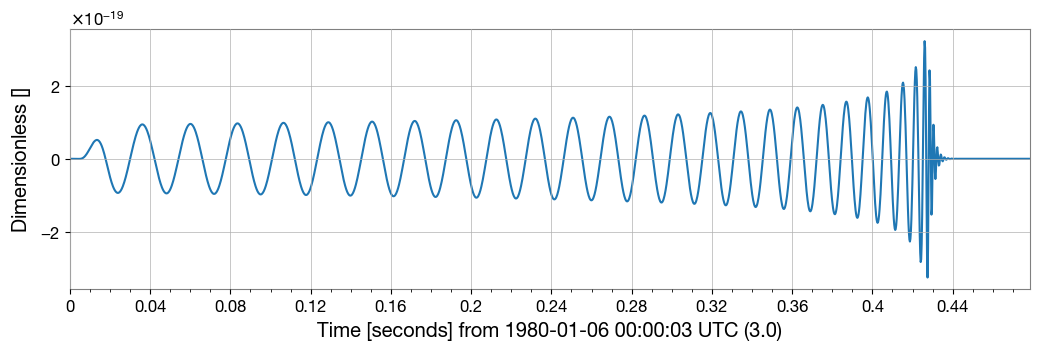

In [29]:
###### Issue Resolved

# This code cell demonstrates the changing of the start time of the bbh signal by modifying it's t0
# This method does not work for t0 >= 2 as shown below (raise an issue on gwpy)
# Find a fix or some alternative

### Solution: It is actually working, there is no problem with the changing of the start time
### In the graph, the time starts from the given t0, but instead of it being shown on the axis,
### it is being shown as UTC (a secs) + offset secs, where t0 = a + offset, and offset is the value
### from which the axis starts. Hence, keep using it as usual.

bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50),
                                               mass2=(10, 50))
bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=1)
print(bbh_two_mass_samples)

hp, hc = get_td_waveform(approximant='SEOBNRv2',
                                mass1=bbh_two_mass_samples[0][0],
                                mass2=bbh_two_mass_samples[0][1],
                                delta_t=1.0/4096,
                                f_lower=40)

signal = TimeSeries.from_pycbc(hp)
signal.plot()

signal = signal.taper()

signal.t0 = 0
signal.plot()

signal.t0 = 1
signal.plot()

signal.t0 = 2
signal.plot()

signal.t0 = 3
signal.plot()

[(43.46216568, 23.18784472)]


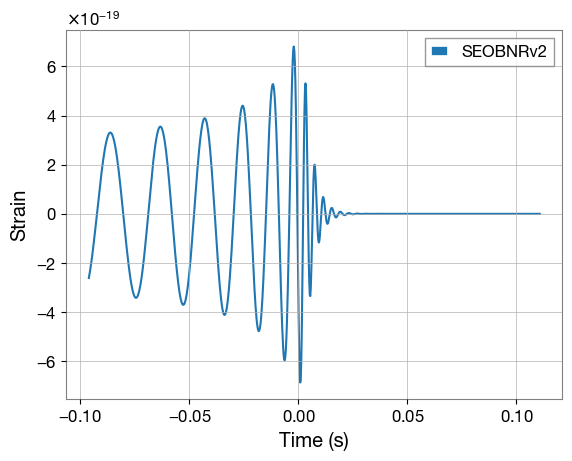

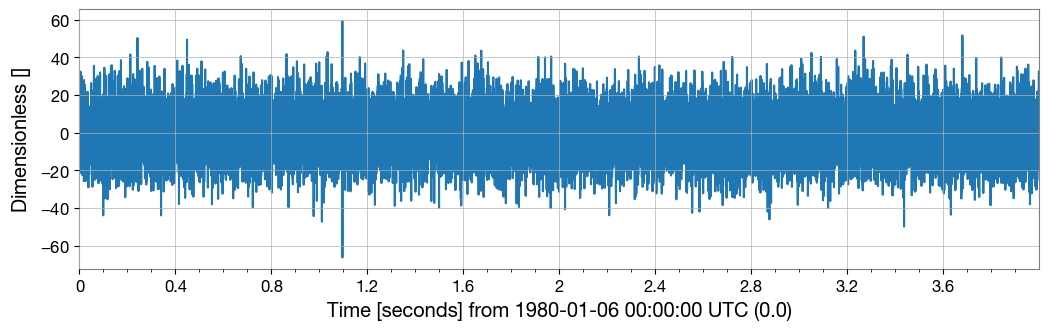

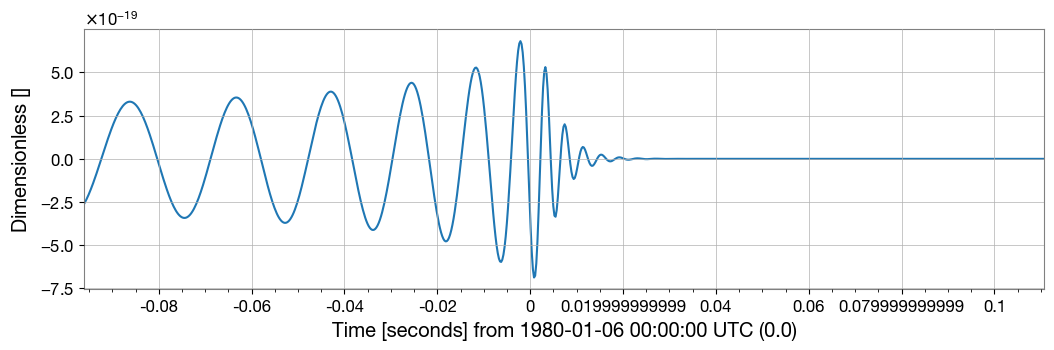

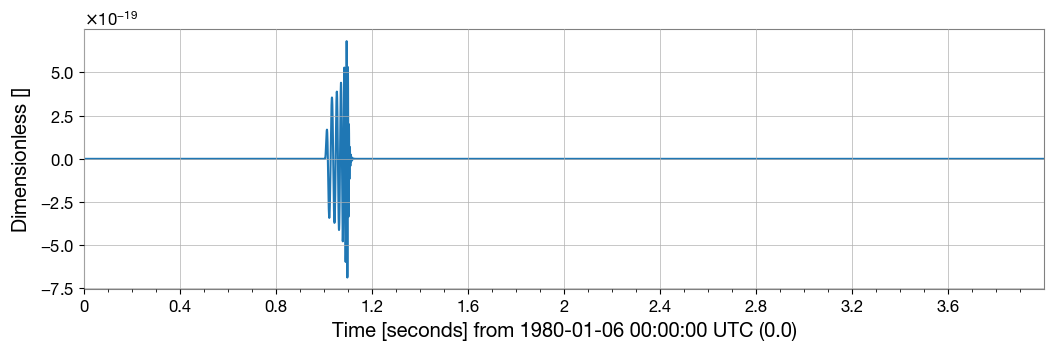

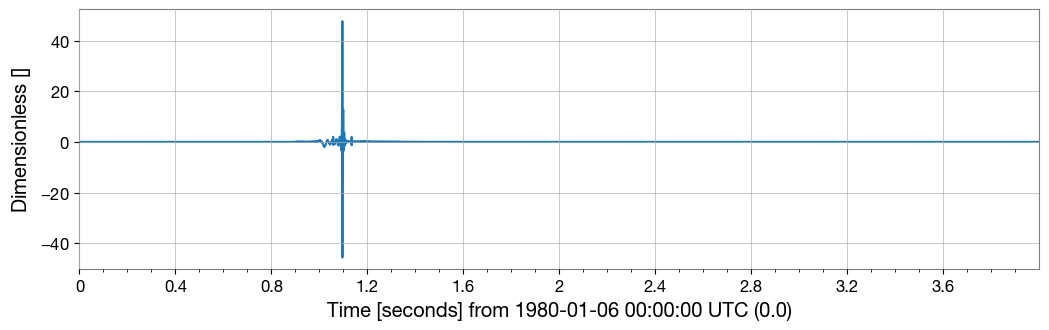

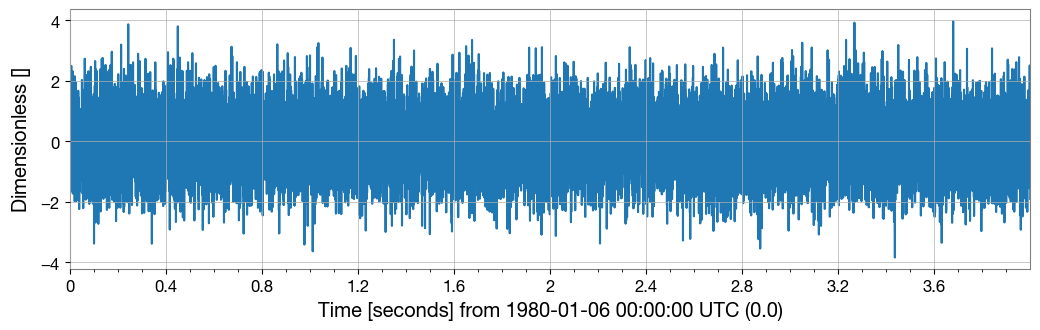

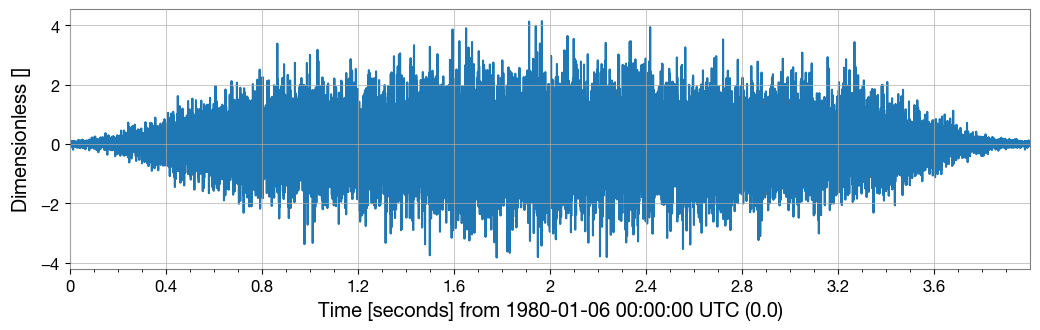

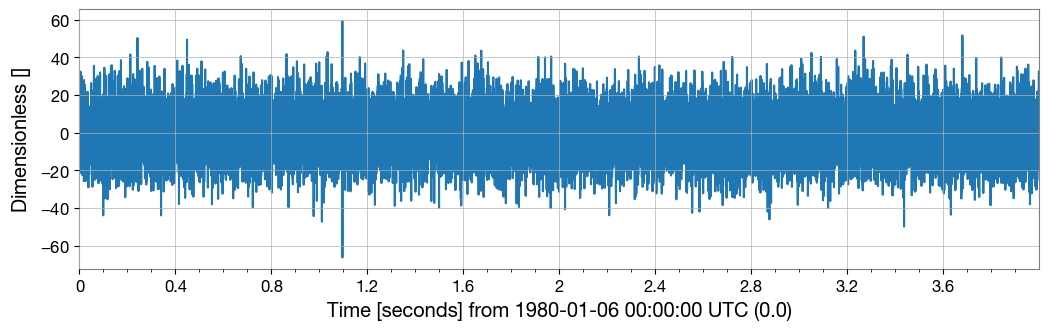

In [30]:
# This code cell demonstrates the method and effect of whitening on signals.

import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.distributions import Uniform
from gwpy.timeseries import TimeSeries

# Generate random binary black hole masses
bbh_two_mass_distributions = Uniform(mass1=(10, 50), mass2=(10, 50))
bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=1)
print(bbh_two_mass_samples)

# Generate waveform
hp, hc = get_td_waveform(approximant='SEOBNRv2',
                         mass1=bbh_two_mass_samples[0][0],
                         mass2=bbh_two_mass_samples[0][1],
                         delta_t=1.0/4096,
                         f_lower=40)

plt.plot(hp.sample_times, hp, label='SEOBNRv2')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Convert to TimeSeries and preprocess
signal = TimeSeries.from_pycbc(hp)
signal.plot()
signal = signal.taper()
signal.t0 = 1  # Set time reference

# **Fix: Ensure noise has the correct dtype (float)**
noise = TimeSeries(np.zeros(16384, dtype=np.float64), sample_rate=4096)  # Ensure float dtype
noise *= 1e-18  # Now this multiplication won't cause type errors

# Inject signal into noise and plot
data = noise.inject(signal)
data.plot()

# Apply whitening and plot
white = data.whiten()
white.plot()

# Generate new Gaussian noise with float dtype
noise = TimeSeries(np.random.normal(scale=1.0, size=16384).astype(np.float64), sample_rate=4096)
noise.plot()
noise *= 13  # Scale noise
white1 = noise.whiten()
white1.plot()

# Inject whitened data and plot
data1 = noise.inject(white)
data1.plot()

[(38.29184314, 17.01056214)]


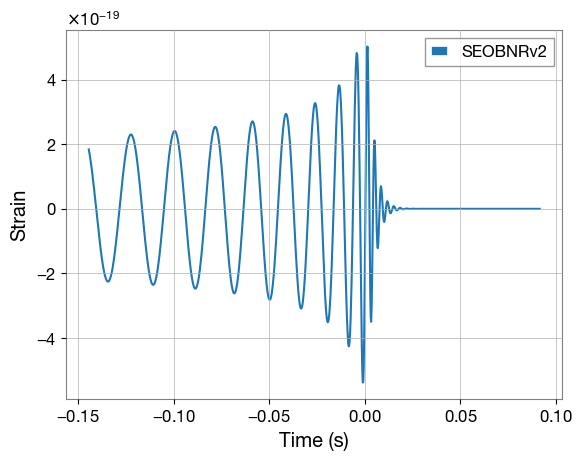

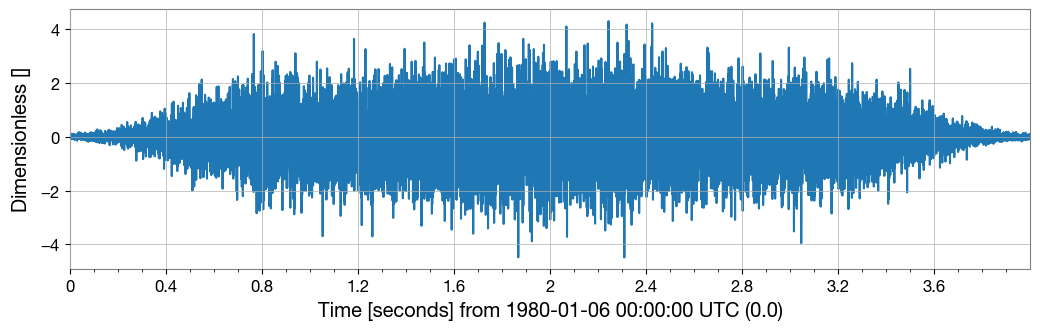

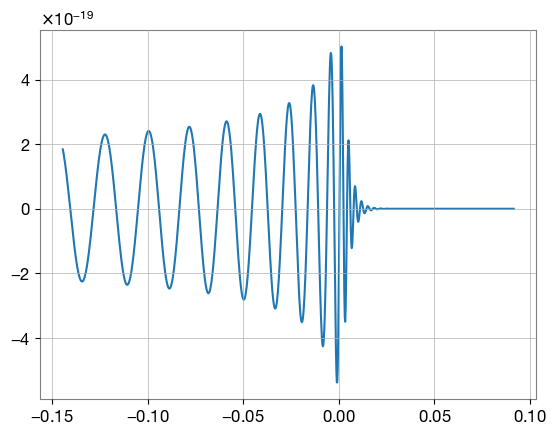

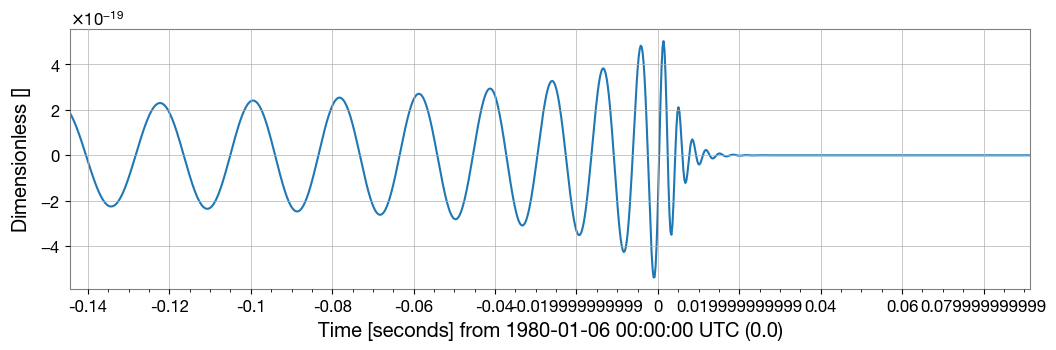

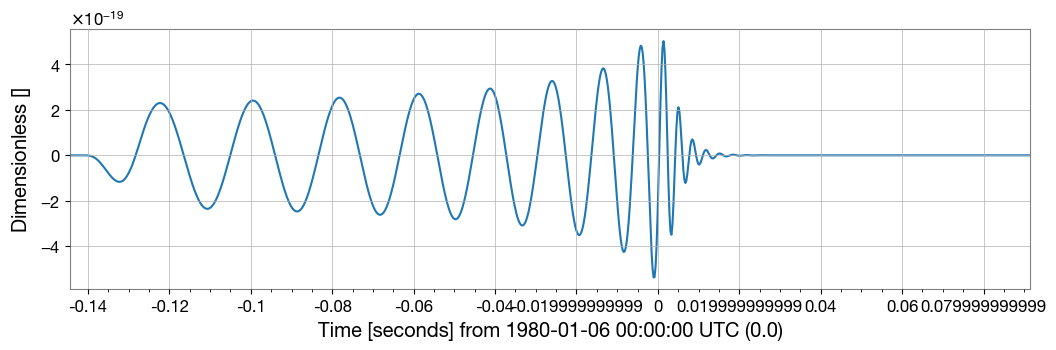

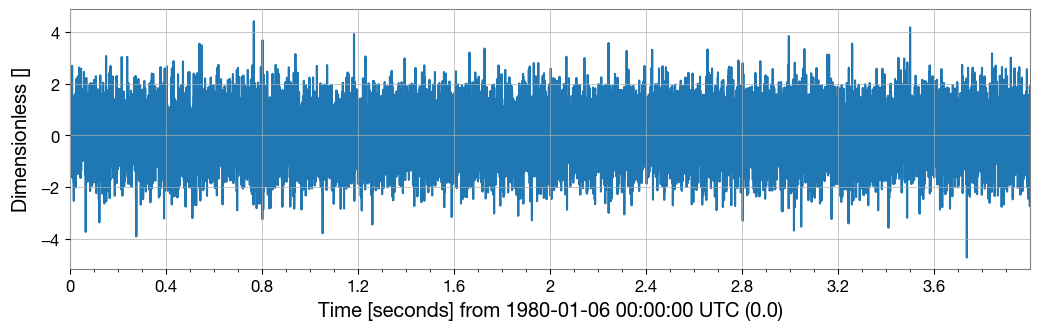

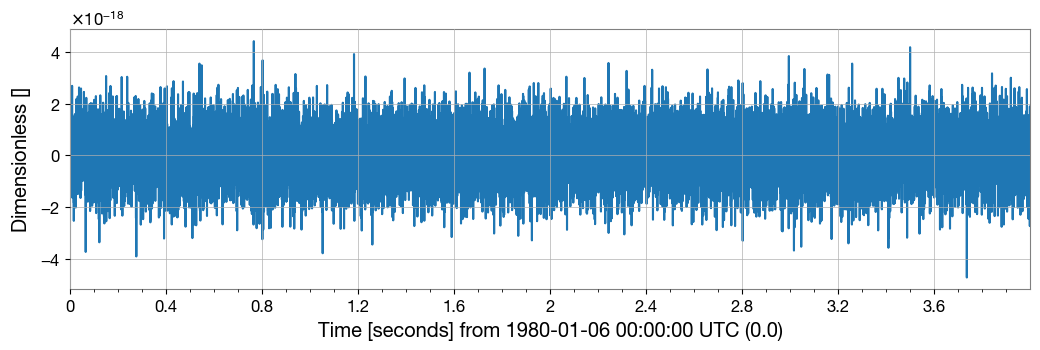

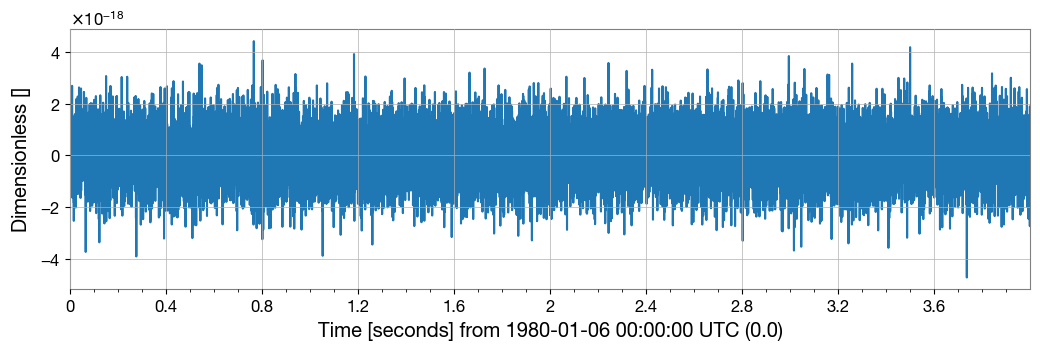

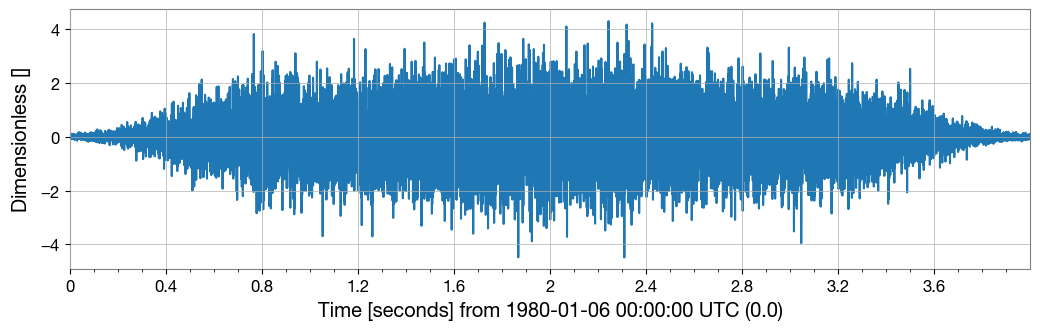

In [31]:
# This code cell demonstrates the effect of the change of the scale in the noise generation from 0.1 to 1
# Notice that changing the scale changes the amplitude of the noise
# With scale = 1, the signal is no longer visible in the noise whereas with scale = 0.1, the signal is clearly visible in the noise

bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50),
                                               mass2=(10, 50))

bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=1)
print(bbh_two_mass_samples)

hp, hc = get_td_waveform(approximant='SEOBNRv2',
                                mass1=bbh_two_mass_samples[0][0],
                                mass2=bbh_two_mass_samples[0][1],
                                delta_t=1.0/4096,
                                f_lower=40)

plt.plot(hp.sample_times, hp, label='SEOBNRv2')

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

hp.plot()

signal = TimeSeries.from_pycbc(hp)
signal.plot()

signal = signal.taper()
signal.plot()
signal.t0 = 1

noise = TimeSeries(np.random.normal(scale=1, size=16384), sample_rate=4096)
noise.plot()    
noise *= 1e-18

noise.plot()
data = noise.inject(signal)
data.plot()

white = data.whiten()
white.plot()

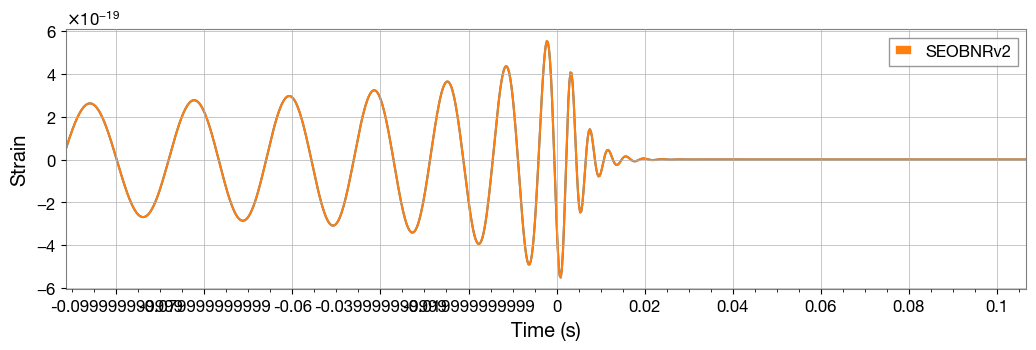

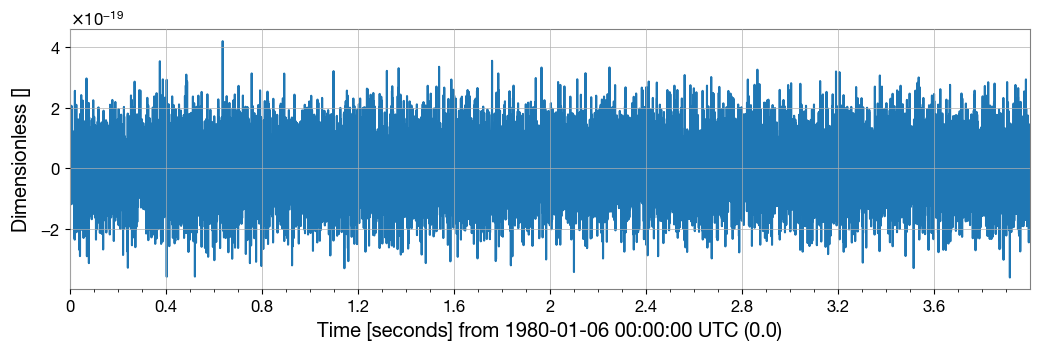

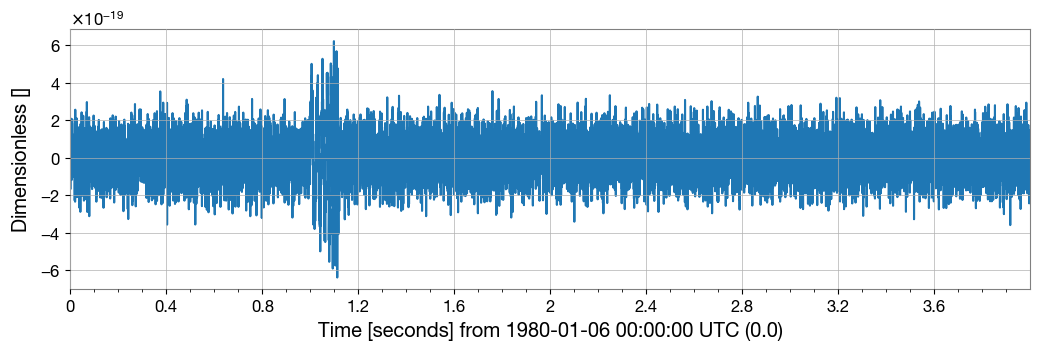

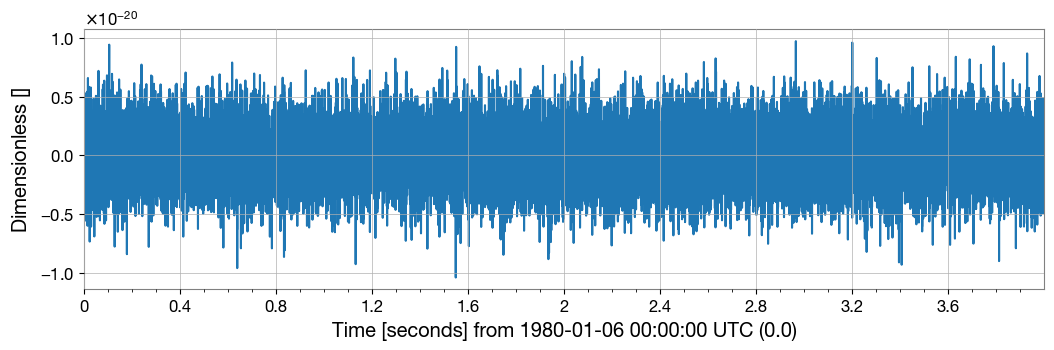

In [ ]:
i = 4533

bbh = TimeSeries.read("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/bbh_signal/bbh_4k_"+str(i)+".txt")
fig1 = bbh.plot()
plt.plot(bbh, label='SEOBNRv2')

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

noise = TimeSeries.read("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/noise_templates/noise_4k_"+str(i)+".txt")
fig1 = noise.plot()

merged_bbh = TimeSeries.read("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/merged_bbh_noise_signal/merged_noise_signal_"+str(i)+".txt")
fig1 = merged_bbh.plot()

merged_bns = TimeSeries.read("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/raw_data_files/merged_bns_noise_signal/bns_merged_noise_signal_"+str(0)+".txt")
fig1 = merged_bns.plot()




In [33]:
# This code cell is an attempt to calculate the SNR. For the source of this code, look at the SNR calculation tutorial
# website in the bookmark folder

# high = merged_bbh.highpass(15)
psd = merged_bbh.psd(4, 2)

from pycbc.filter import matched_filter
snr = matched_filter(bbh, merged_bbh, psd=psd,
                     low_frequency_cutoff=15)
snrts = TimeSeries.from_pycbc(snr).abs()


TypeError: Can only convert a TimeSeries to a FrequencySeries

In [ ]:
plot = snrts.plot()
plot.show()

In [ ]:
######## Another method of noise generation

import pycbc.noise
import pycbc.psd


# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 4 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(4 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

plt.plot(ts.sample_times, ts)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
from gwpy.plot import Plot

plot = Plot(noise, bbh, merged_bbh, separate=True, sharex=True, sharey=True)
plot.gca().set_epoch(0)
plot.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from gwpy.timeseries import TimeSeries
from astropy.utils.data import get_readable_fileobj
from gwpy.plot import Plot

# Generate noise with a sample rate of 4096 Hz
noise = TimeSeries(random.normal(scale=0.1, size=16384), sample_rate=4096)

# Fetch signal data from URL
url = ("https://www.gw-openscience.org/s/events/GW150914/P150914/"
       "fig2-unfiltered-waveform-H.txt")

with get_readable_fileobj(url) as f:
    signal = TimeSeries.read(f, format='txt')

# Ensure signal aligns with noise
signal.t0 = 0.5  # Align time reference

# **Fix: Resample the signal to match the noise sample rate (4096 Hz)**
signal = signal.resample(4096)

# Process the signal
signal = signal.taper()

# Inject resampled signal into noise
data = noise.inject(signal)

# Plot the noise
plot = Plot(noise)
plot.gca().set_epoch(0)
plot.show()

In [ ]:
#################################################
############ DATASET DEBUGGING END ##############
#################################################

In [ ]:
##################################################################################################################################
##################################################################################################################################

In [ ]:

path_n = "4s_new_generated_data/4s_noise_template_4k/"


path_s = "4s_new_generated_data/4s_bns_template_4k/"

for i in tqdm(range(3)):
    s = TimeSeries.read(path_s+"4s_bns_4k_"+str(i+1)+".txt")
    n = TimeSeries.read(path_n+"4s_noise_4k_"+str(i+1)+".txt")
    st = np.random.randint(0,2)
    s.t0 = st
    data = n.inject(s)
    pylab.plot(n)
    pylab.plot(s)
        
    data.write("4s_new_generated_data/4s_merged_bns_noise_signal/4s_merged_noise_signal_"+str(i+1)+".txt")
pylab.show()

In [ ]:
hp_bns, hc_bns = get_td_waveform(approximant="IMRPhenomPv2_NRTidal",
                         mass1=bns_two_mass_samples[3][0],
                         mass2=bns_two_mass_samples[3][1],
                         delta_t=1.0/4096,
                         f_lower=200)
s = TimeSeries.read(path_s+"4s_bns_4k_"+str(1)+".txt")
n = TimeSeries.read(path_n+"4s_noise_4k_"+str(1)+".txt")
pylab.plot(hp_bns.sample_times, hp_bns)
n= n*(1e-19)
pylab.scatter(n, range(16384))
pylab.show()

In [ ]:
hp_bns, hc_bns = get_td_waveform(approximant="IMRPhenomPv2_NRTidal",
                  mass1=2,
                   mass2=1.5,
                     delta_t=1.0/4096,
                      f_lower=40)
pylab.scatter(hp_bns.sample_times,hp_bns)

In [ ]:
s = TimeSeries.from_pycbc(hp_bns)
pylab.plot(s)



In [ ]:
d = n.inject(s)
pylab.plot(d)

In [ ]:
pylab.scatter(d,range(16384))
pylab.scatter(n*1e-18,range(16384))

In [ ]:
df = {}

files= "4s_new_generated_data/5000_4s_merged_bbh_noise_signal_no_abs/"
data = [] # pd.concat takes a list of dataframes as an agrument
for i in range(5):
    x=[]
    
    print(csv)
    frame = pd.read_csv(files+"5000_4s_merged_noise_signal_3501"+str(i+1)+".txt",sep = ' ', header=None)
    
    print(frame)
    file_name = os.path.basename(csv)
    print(file_name)
    data.append(frame[:][1])
    x  = list(frame[:][1])
    print(x)
    df['signal_noise_template_'+str(i+1)] = x
print(df)

df1 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df.items() ]))
print(df1)
df1_transposed = df1.T
print(df1_transposed)
df1.to_csv("4s_new_generated_data/sample_signal_noise.csv", index=None)

In [ ]:
df = {}

files= "4s_new_generated_data/5000_4s_noise_template_4k_no_abs/"
data = [] # pd.concat takes a list of dataframes as an agrument
for i in range(5):
    x=[]
    
    print(csv)
    frame = pd.read_csv(files+"5000_4s_noise_4k_350"+str(i+1)+".txt",sep = ' ', header=None)
    
    print(frame)
    file_name = os.path.basename(csv)
    print(file_name)
    data.append(frame[:][1])
    x  = list(frame[:][1])
    print(x)
    df['pure_noise_template_'+str(i+1)] = x
print(df)

df1 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df.items() ]))
print(df1)
df1= df1*1e-17
print(df1)
df1_transposed = df1.T
print(df1_transposed)
df1.to_csv("4s_new_generated_data/sample_pure_noise.csv", index=None)

In [ ]:
df = {}

files= "4s_new_generated_data/5000_4s_bbh_template_4k_no_abs/"
data = [] # pd.concat takes a list of dataframes as an agrument
for i in range(5):
    x=[]
    
    print(csv)
    frame = pd.read_csv(files+"5000_4s_bbh_4k_350"+str(i+1)+".txt",sep = ' ', header=None)
    
    print(frame)
    file_name = os.path.basename(csv)
    print(file_name)
    data.append(frame[:][1])
    x  = list(frame[:][1])
    print(x)
    df['only_signal_template_'+str(i+1)] = x
print(df)

df1 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df.items() ]))
print(df1)

df1_transposed = df1.T
print(df1_transposed)
df1.to_csv("4s_new_generated_data/sample_signal.csv", index=None)

In [ ]:
df = pd.read_csv("4s_new_generated_data/sample_pure_noise.csv", header=None)
print(df.shape)

In [ ]:
print(df)
df = df.iloc[0: , :]
print(df[0])

plt.plot(df[0])
plt.show()

In [ ]:
df = pd.read_csv("4s_new_generated_data/5000_4s_bbh_template_4k_no_abs/5000_4s_bbh_4k_3501.txt",sep=' ', header=None)
print(df)


# Injection at any arbitrary position

100%|██████████| 200/200 [00:21<00:00,  9.11it/s]


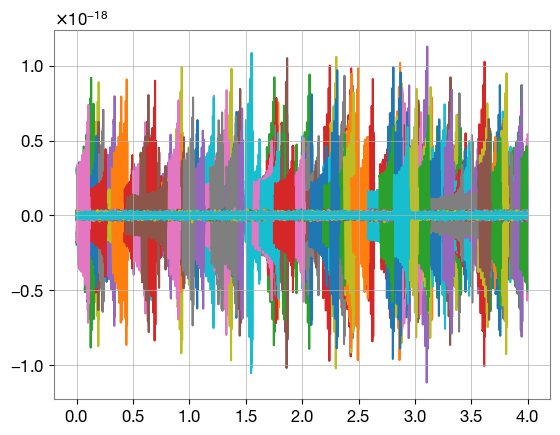

In [34]:
bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50),
                                               mass2=(10, 50))

bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=200)

for i in tqdm(range(len(bbh_two_mass_samples))):
    hp, hc = get_td_waveform(approximant="SEOBNRv2",                               
                         mass1=bbh_two_mass_samples[i][0],
                         mass2=bbh_two_mass_samples[i][1],
                         delta_t=1.0/4096,
                         f_lower=40)                                                

    noise = TimeSeries(np.random.normal(scale=.1, size=16384), sample_rate=4096)   
    noise= noise*1e-19
    
    signal = TimeSeries.from_pycbc(hp)
    st = np.random.randint(0,64)
    
    signal.t0 = 0.0625*st #### Keep dividing 0.5 by 2, you can go beyond 0.0625 too (try 0.0625/2)
    data = noise.inject(signal)

    plt.plot(data)